# Fine tuning CLIP for image captions

This notebook will show how to use DataChain for multimodal AI, including how to:
- [Ingest multimodal data like images and text.](#ingesting)
- [Join those data into a coherent dataset.](#joining)
- [Filter and inspect the data.](#filtering)
- [Calculate similarities between images and text.](#similarities)
- [Save the chain results as a dataset](#saving)
- [Apply/map functions to transform the data and chain transformations.](#mapping)
- [Train models from the chained data.](#training)
- [Perform inference and calculate evaluation metrics.](#eval)

<a id='setup'></a>

## Setup

To start, install the dependencies and import the packages needed.

In [1]:
!pip install -q ipywidgets datachain git+https://github.com/openai/CLIP.git

In [2]:
import io
import os
import string

import clip
import torch
from datachain.torch import clip_similarity_scores
from datachain import C, DataChain
from torch.utils.data import DataLoader

<a id='ingesting'></a>

## Get data and create DataChain

We will use a dataset from https://www.capcon.dev/, which is based on the New Yorker Cartoon Caption Contest. We use the "matching" dataset, which pairs a cartoon image with several possible jokes as caption choices. By the end of this notebook, we will try to predict the correct joke that matches the cartoon from each set of multiple choices.

To start, we have two data sources in `gs://datachain-demo/newyorker_caption_contest`:
1. `images`: A folder of JPEG files, each representing a cartoon image.
2. `new_yorker_meta.parquet`: A parquet file with metadata about the images, including multiple choices of captions for the image and the correct caption choice.

We can create a DataChain from each of the two data sources.
1. DataChain can create a single dataset from many files in a storage bucket, folder, or other path. DataChain will generate one record per file, with each record including a `file` signal that saves metadata needed to read the file. In that way, DataChain keeps a link to the original storage without having to copy the files or load all file contents in memory.
2. DataChain can also create a dataset from other traditional data sources like parquet files without copying those files or loading them entirely in memory. This provides an efficient way to connect data from a variety of sources.

<details>
<summary>Note about the dataset format</summary>
We have slightly modified the dataset from its original form in Hugging Face. The original dataset keeps the entire contents of each image embedded as a column in parquet files. That will not scale easily to large datasets, which is why DataChain keeps the image files in their original locations and reads from them as needed. We have dropped the image contents from the parquet files and only kept the metadata. The images are instead saved as regular JPEG files.
</details>

### From storage

To create a chain from a directory of files, use `DataChain.from_storage()` and point to the location of the directory. Use the `type` argument to specify a type like `binary`, `text`, or `image`, which will tell DataChain how to open these files later in the chain:

In [3]:
img_dc = DataChain.from_storage("gs://datachain-demo/newyorker_caption_contest/images", type="image")

You may be wondering why you don't see any results. DataChain tries to compute the entire chain lazily, waiting until you explicitly ask for a result before executing. To preview the results, use `DataChain.show()`:

In [4]:
img_dc.show(3)

Processed: 422 rows [00:00, 21777.33 rows/s]


,file,file,file,file,file,file,file,file,file,file
,source,parent,name,size,version,etag,is_latest,last_modified,location,vtype
0,gs://datachain-demo,newyorker_caption_contest/images,101.jpeg,26023,1719848704083399,CMeLzNiXhocDEAE=,1,1970-01-01 00:00:00+00:00,None,
1,gs://datachain-demo,newyorker_caption_contest/images,102.jpeg,10114,1719848704201349,CIWl09iXhocDEAE=,1,1970-01-01 00:00:00+00:00,None,
2,gs://datachain-demo,newyorker_caption_contest/images,104.jpeg,18254,1719848704491291,CJv+5NiXhocDEAE=,1,1970-01-01 00:00:00+00:00,None,



[Limited by 3 rows]


DataChain created a record for each file in the directory, generating a `file` signal for each file. The file signal contains subsignals with metadata about each file, like `file.name` and `file.size`. You can define your own aggregate signals like this using Pydantic models, although this is outside the scope of this tutorial. You can also use the `file` signal to open and read the file as needed. We will come back to this later in the notebook.

### From parquet

Use `DataChain.from_parquet()` to load data from a dataset of any number of parquet files (you can also read the data into another library like pandas and use `DataChain.from_dataframe()`). Here we use it to load the metadata about the cartoons, including the text for all caption choices.

In [5]:
meta_dc = DataChain.from_parquet("gs://datachain-demo/newyorker_caption_contest/new_yorker_meta.parquet")

Processed: 1 rows [00:00, 1503.87 rows/s]


Let's preview the parquet data:

In [6]:
meta_dc.show(3)

Processed: 1 rows [00:00, 1458.38 rows/s]
Processed: 0 rows [00:00, ? rows/s]
Processed: 1 rows [00:00,  2.76 rows/s]
Generated: 9792 rows [00:00, 27041.96 rows/s]


,source,source,source,source,source,source,source,source,source,source,source,contest_number,image_location,image_description,image_uncanny_description,entities,questions,caption_choices,from_description,label,n_tokens_label,instance_id,filename
,file,file,file,file,file,file,file,file,file,file,index,,,,,,,,,,,,
,source,parent,name,size,version,etag,is_latest,last_modified,location,vtype,,,,,,,,,,,,,
0,gs://datachain-demo,newyorker_caption_contest,new_yorker_meta.parquet,3765680,1719847348473242,CJqbmNKShocDEAE=,1,1970-01-01 00:00:00+00:00,None,,0,49,a bar,Two priests and a rabbi are walking into a bar...,"The scene depicts a very stereotypical ""bar jo...",[https://en.wikipedia.org/wiki/Rule_of_three_(...,[What is the bartender saying on the phone in ...,"[Tell me about your childhood very quickly., B...",scene: a bar description: Two priests and a ra...,C,1,21125bb8787b4e7e82aa3b0a1cba1571,49.jpeg
1,gs://datachain-demo,newyorker_caption_contest,new_yorker_meta.parquet,3765680,1719847348473242,CJqbmNKShocDEAE=,1,1970-01-01 00:00:00+00:00,None,,1,393,clouds,"Two men are standing on clouds, one is dressed...",Seeing two men standing on clouds and holding/...,"[https://en.wikipedia.org/wiki/God, https://en...",[Why are these men standing on clouds holding/...,"[Business school changed you, Son., I'm a thro...",scene: clouds description: Two men are standin...,A,1,87056539d887b9b38cb33ee8101c2c99,393.jpeg
2,gs://datachain-demo,newyorker_caption_contest,new_yorker_meta.parquet,3765680,1719847348473242,CJqbmNKShocDEAE=,1,1970-01-01 00:00:00+00:00,None,,2,703,restaurant,An alligator is coming out of the floor. Two p...,There is an alligator coming out of the floor.,"[https://en.wikipedia.org/wiki/Alligator, http...",[Why is an alligator in a restaurant?],[Where were you between the hours of beddy-bye...,scene: restaurant description: An alligator is...,D,1,3ef377604288fc61e83dd2341f1567de,703.jpeg



[Limited by 3 rows]


DataChain created a record for each row in the parquet dataset, including a `source` signal similar to the `file` signal above that stores information about the source parquet file, as well as signals for all of the columns in the parquet file.

Since we are not interested in the `source` at the moment, we can select only the other columns to preview using `DataChain.select()` or `DataChain.select_except()`. For aggregate signals like `source`, you can select it either in the aggregate (like `source`) or any individual subsignal (like `source.index`).

In [7]:
meta_dc.select_except("source").show(3)

Processed: 1 rows [00:00, 1499.57 rows/s]
Processed: 0 rows [00:00, ? rows/s]
Generated: 0 rows [00:00, ? rows/s]
Processed: 1 rows [00:00,  2.31 rows/s]ows/s]
Generated: 9792 rows [00:00, 22612.23 rows/s]


,contest_number,image_location,image_description,image_uncanny_description,entities,questions,caption_choices,from_description,label,n_tokens_label,instance_id,filename
0,49,a bar,Two priests and a rabbi are walking into a bar...,"The scene depicts a very stereotypical ""bar jo...",[https://en.wikipedia.org/wiki/Rule_of_three_(...,[What is the bartender saying on the phone in ...,"[Tell me about your childhood very quickly., B...",scene: a bar description: Two priests and a ra...,C,1,21125bb8787b4e7e82aa3b0a1cba1571,49.jpeg
1,393,clouds,"Two men are standing on clouds, one is dressed...",Seeing two men standing on clouds and holding/...,"[https://en.wikipedia.org/wiki/God, https://en...",[Why are these men standing on clouds holding/...,"[Business school changed you, Son., I'm a thro...",scene: clouds description: Two men are standin...,A,1,87056539d887b9b38cb33ee8101c2c99,393.jpeg
2,703,restaurant,An alligator is coming out of the floor. Two p...,There is an alligator coming out of the floor.,"[https://en.wikipedia.org/wiki/Alligator, http...",[Why is an alligator in a restaurant?],[Where were you between the hours of beddy-bye...,scene: restaurant description: An alligator is...,D,1,3ef377604288fc61e83dd2341f1567de,703.jpeg



[Limited by 3 rows]


<a id='joining'></a>

### Joining

To compare the images to the text caption choices, we need to join both chains by matching the rows using the name of the image file. For `img_dc`, this field is captured automatically in `file.name`. For `meta_dc`, the `filename` is a column in the parquet file identifying the corresponding JPEG file.

In [8]:
dc = img_dc.merge(meta_dc, on="file.name", right_on="filename")

The resulting chain includes the union of all columns from both of the initial chains. Since this is a lot of columns, let's take a look at just a subset of columns of interest:

In [9]:
dc.select("file.name", "caption_choices", "label").show(3)

Processed: 422 rows [00:00, 20053.89 rows/s]
Processed: 1 rows [00:00, 1474.79 rows/s]
Processed: 0 rows [00:00, ? rows/s]
Processed: 1 rows [00:00,  2.83 rows/s]
Generated: 9792 rows [00:00, 27718.96 rows/s]


,file,caption_choices,label
,name,,
0,101.jpeg,"[And, if you open the window, the view will ta...",C
1,101.jpeg,"[And, if you open the window, the view will ta...",C
2,101.jpeg,"[And, if you open the window, the view will ta...",C



[Limited by 3 rows]


<a id='ingestion'></a>

## Filtering and inspecting a sample

Let's take a look at one sample cartoon from the dataset to see how it looks.

`DataChain.filter()` allows for filtering of the dataset. In this case, we will filter to a single JPEG image using `file.name`. There are multiple rows of metadata for each image, since there can be different combinations of image and caption choices or other metadata, so we will also limit to one output row:

In [10]:
sample = dc.filter(C("file.name") == "371.jpeg").limit(1)

We can use `DataChain.collect()` to extract the values from the sample. Here's an example of collecting a subset of column signals from the sample:

In [11]:
sample_results = sample.collect("file", "caption_choices", "label")
sample_results

Processed: 422 rows [00:00, 21219.67 rows/s]
Processed: 1 rows [00:00, 1623.81 rows/s]
Processed: 0 rows [00:00, ? rows/s]
Generated: 0 rows [00:00, ? rows/s]
Processed: 1 rows [00:00,  2.33 rows/s]ows/s]
Generated: 9792 rows [00:00, 22817.37 rows/s]


[[ImageFile(source='gs://datachain-demo', parent='newyorker_caption_contest/images', name='371.jpeg', size=25555, version='1719848719616822', etag='CLaWgOCXhocDEAE=', is_latest=True, last_modified=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), location=None, vtype=''),
  ['Can you please identify which hand was mistakenly amputated?',
   "Frank called to say he'll be late, he's stuck at the office.",
   'Your overhead is going to kill you.',
   'Just the worm, hold the Tequila.',
   'Calm down, I just came to get my things.'],
  'E']]

The example has an output for each signal:
- `file` returns a special `ImageFile` object (see below).
- `caption_choices` returns a list with the text for each of the 5 caption choices.
- `label` return the correct caption choice as a letter (A-E).

DataChain knows to return `file` as an `ImageFile` because we created the chain for the image files with `DataChain.from_storage(..., type="image")`. `ImageFile` is a subclass of `File`. All `File` types include methods to do file operations like `file.open()` and `file.read()`. Use `file.read()` to return the image itself as type `PIL.Image.Image`.

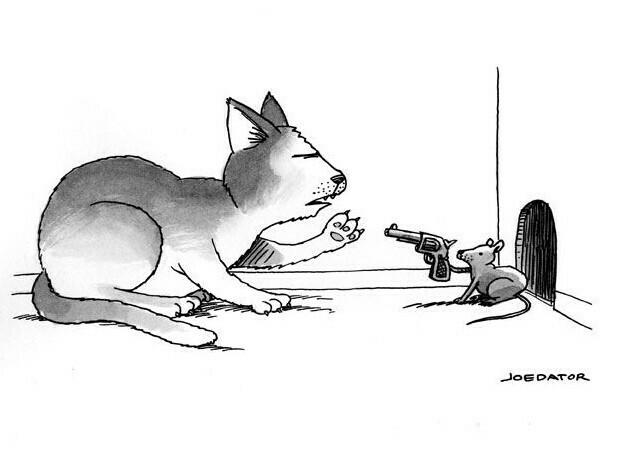

In [12]:
example = sample_results[0]
example[0].read()

<a id='similarities'></a>

## Predict caption similarities with CLIP

Let's use the CLIP model (https://github.com/openai/CLIP) to predict similarity scores between the cartoon and the caption choices.

To start, we need to load the model:

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

To get similarity scores for each image/text pair, we need to:
1. Preprocess the image to transform it into a torch tensor with the expected dimensions
2. Tokenize the text to get the tokens for each word to pass to the model
3. Pass both of these values to the model to get the cosine similarities for each image-text combination.

Here's how to do this for our current example:

In [14]:
image = example[0].read()
image = preprocess(image).unsqueeze(0)
text = clip.tokenize(example[1])
logits_per_image, logits_per_text = model(image, text)
logits_per_image

tensor([[20.2135, 23.0318, 21.6857, 23.2001, 22.4901]], grad_fn=<MmBackward0>)

To predict the probability of each caption choice, we can perform a softmax operation across these scores:

In [15]:
logits_per_image.softmax(dim=1)[0]

tensor([0.0194, 0.3241, 0.0844, 0.3836, 0.1886], grad_fn=<SelectBackward0>)

We can use `DataChain.torch.clip_similarity_scores()` to reduce this to a one-liner. It takes the following parameters:
- `images`: any number of images as inputs
- `text`: any number of text values as inputs
- `model`: CLIP model
- `preprocess`: image preprocessor
- `tokenizer`: text tokenizer
- `prob`: whether to return probabilities or raw cosine similarities

In [16]:
clip_similarity_scores(example[0].read(), example[1], model, preprocess, clip.tokenize, prob=True)[0]

/Users/dave/Code/datachain/src/datachain/lib/text.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return encoder(torch.tensor(tokens))


[0.019353175535798073,
 0.324138879776001,
 0.08436062932014465,
 0.3835700452327728,
 0.18857727944850922]

<a id='saving'></a>

## Saving the chain

We'll need to apply these similarities across our dataset for fine-tuning. To start, let's create a small random training sample using `DataChain.shuffle()`, which returns the records in a deterministic random order.

The result is saved using `DataChain.save()`. This will save a persistent, versioned dataset that we can recover anytime in the future. It also will prevent DataChain from recomputing the same steps when running the chain again.

In [17]:
train_dc = dc.shuffle().limit(10).save("newyorker_caption_contest_train")

Processed: 422 rows [00:00, 18592.79 rows/s]
Processed: 1 rows [00:00, 1009.95 rows/s]
Processed: 0 rows [00:00, ? rows/s]
Processed: 1 rows [00:00,  2.80 rows/s]
Generated: 9792 rows [00:00, 27463.04 rows/s]


<a id='mapping'></a>

## Mapping the similarity function to the dataset and chaining operations

How do we calculate similarity scores across the entire sample? You can use `DataChain.map()` to map this function onto each record in the sample. It takes the following parameters:

- `func`: The function to map to each record.
- `params`: The signals names from the chain to use as input parameters to the function.
- `output`: The dict of output signal names and types in format `{column_name: column_type}`.

In [18]:
train_dc = train_dc.map(
    func=lambda img_file, txt: clip_similarity_scores(img_file.read(), txt, model, preprocess, clip.tokenize, prob=True)[0],
    params=["file", "caption_choices"],
    output={"scores": list[float]}
)

We use `clip_similarity_scores()` from above to make a one-line lambda function, but if you need to customize your mapper function, you can pass any function as long as it:
- takes the `params` signal types as input
- returns the types specified in `output`

Next, we want to calculate the probability that each record predicted the correct caption.
Using `DataChain.map()`, we can write our own functions to add new signals to the data and chain them together.

We need two functions:
- `label_ind()`: Takes the label column which contains a letter A-E and maps it to an integer 0-4.
- `label_prob()`: Returns the predicted probability of that label.

In [19]:
def label_ind(label):
    return string.ascii_uppercase.index(label)

def label_prob(scores, label_ind):
    return scores[label_ind]

To apply these to the sample, we can chain together multiple `map()` operations:

In [20]:
train_dc = (
    train_dc.map(label_ind, params=["label"], output={"label_ind": int})
    .map(label_prob, params=["scores", "label_ind"], output={"label_prob": float})
)

Like other DataChain operations, the entire chain of operations here is lazy until we invoke some greedy computation, so we have not actually performed any of these transformations yet. We can save again to force computation:

In [21]:
train_dc = train_dc.save()

Download: 0.00B [00:00, ?B/s]
Download: 26.6kB [00:00, 71.4kB/s]]
Download: 45.3kB [00:00, 72.8kB/s]ws/s]
Download: 63.9kB [00:00, 70.2kB/s]ws/s]
Download: 82.5kB [00:01, 73.6kB/s]ws/s]
Download: 101kB [00:01, 76.2kB/s] ws/s]
Download: 120kB [00:01, 68.8kB/s]ows/s]
Download: 138kB [00:01, 71.6kB/s]ows/s]
Download: 157kB [00:02, 72.4kB/s]ows/s]
Download: 176kB [00:02, 73.9kB/s]ows/s]
Download: 186kB [00:02, 72.5kB/s]rows/s]
Processed: 10 rows [00:02,  4.27 rows/s]
Processed: 10 rows [00:00, 4312.02 rows/s]
Processed: 10 rows [00:00, 2847.26 rows/s]


Let's take a look at the results:

In [22]:
train_dc.show(3)

,file,file,file,file,file,file,file,file,file,file,source,source,source,source,source,source,source,source,source,source,source,contest_number,image_location,image_description,image_uncanny_description,entities,questions,caption_choices,from_description,label,n_tokens_label,instance_id,filename,scores,label_ind,label_prob
,source,parent,name,size,version,etag,is_latest,last_modified,location,vtype,file,file,file,file,file,file,file,file,file,file,index,,,,,,,,,,,,,,,
,,,,,,,,,,,source,parent,name,size,version,etag,is_latest,last_modified,location,vtype,,,,,,,,,,,,,,,,
0,gs://datachain-demo,newyorker_caption_contest/images,208.jpeg,19079,1719848711045222,COaA9duXhocDEAE=,1,1970-01-01 00:00:00+00:00,None,,gs://datachain-demo,newyorker_caption_contest,new_yorker_meta.parquet,3765680,1719847348473242,CJqbmNKShocDEAE=,1,1970-01-01 00:00:00+00:00,None,,8515,208,a car,Two people are sitting inside the car. They ar...,They look to be trying to row the car.,"[https://en.wikipedia.org/wiki/Rowing, https:/...",[Are they insane?],[Stop complaining. I can be used as a flotatio...,scene: a car description: Two people are sitti...,C,1,9f8cd6d31ded7aff06c07dba2323dc9f,208.jpeg,"[0.06516700983047485, 0.0046694595366716385, 0...",2,0.001401
1,gs://datachain-demo,newyorker_caption_contest/images,208.jpeg,19079,1719848711045222,COaA9duXhocDEAE=,1,1970-01-01 00:00:00+00:00,None,,gs://datachain-demo,newyorker_caption_contest,new_yorker_meta.parquet,3765680,1719847348473242,CJqbmNKShocDEAE=,1,1970-01-01 00:00:00+00:00,None,,3943,208,car,Two people are in the car using paddles. They ...,rowing is for boats. To drive a car you need t...,"[https://en.wikipedia.org/wiki/Paddle, https:/...",[Why are they trying to row a car?],[Stop complaining. I can be used as a flotatio...,scene: car description: Two people are in the ...,C,1,bc6a95b58891fe592ffa60759eb1d7d1,208.jpeg,"[0.06516700983047485, 0.0046694595366716385, 0...",2,0.001401
2,gs://datachain-demo,newyorker_caption_contest/images,208.jpeg,19079,1719848711045222,COaA9duXhocDEAE=,1,1970-01-01 00:00:00+00:00,None,,gs://datachain-demo,newyorker_caption_contest,new_yorker_meta.parquet,3765680,1719847348473242,CJqbmNKShocDEAE=,1,1970-01-01 00:00:00+00:00,None,,3718,208,a car,There are two people in a car. They are using ...,There are two people driving a car with paddles.,"[https://en.wikipedia.org/wiki/Rowing, https:/...",[Why are the people using paddles to drive a c...,"[Yeah, but this race is up the side of a windo...",scene: a car description: There are two people...,E,1,88cfc76b4a9f1bb855ff9107c15f8805,208.jpeg,"[0.08257035911083221, 0.07464107871055603, 0.0...",4,0.800688



[Limited by 3 rows]


Now that we have computed the predicted probability of each label, we can find the average predicted probability of the correct caption. DataChain's aggregation functions can calculate summary metrics. `DataChain.avg()` can be used to calculate the average predicted probability:

In [23]:
train_dc.avg("label_prob")

0.3779400472994894

Let's see if we can improve the average predicted probability using fine tuning.

<a id='training'></a>

## Fine tuning the CLIP model

We can fine tune the CLIP model on our dataset so it can correctly predict the captions. Since our sample for this toy example is a single cartoon, it should be pretty simple for the model to learn which captions are correct.

To fine tune the model, we need to convert the data into a [PyTorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Luckily, `DataChain.to_pytorch()` does just that. We need to select 3 signals from the data to pass to the model:
1. Image files
2. Text caption choices
3. Label indices

`DataChain.to_pytorch()` has a couple helpful arguments to transform our image and text data:
- `transform`: a [torchvision transform](https://pytorch.org/vision/stable/transforms.html) to process the image into the expected torch tensor dimensions.
- `tokenizer`: a tokenizer function (such as a [Hugging Face tokenizer](https://huggingface.co/docs/tokenizers/index)) to convert the raw text into tokens.

The pre-trained CLIP model we loaded earlier includes both of these:
- `preprocess` is a torchvision transform.
- `clip.tokenize` is a tokenizer.

In [24]:
ds = train_dc.select("file", "caption_choices", "label_ind").to_pytorch(
    transform=preprocess,
    tokenizer=clip.tokenize,
)

Now we can write our PyTorch training loop as we normally would. The data is a normal PyTorch `Dataset` at this point, so there's nothing special about this code. For each image, it calculates the similarities to each text caption choice and applies the loss function based on the label of the correct choice.

<details>
<summary>Notes about how we fine-tuned the model</summary>
We won't go into details of CLIP fine-tuning, but take a look at https://github.com/openai/CLIP and especially https://github.com/openai/CLIP/issues/83 if you are interested. Note that the code below is slightly different from typical CLIP training, which normally takes a batch of pairs each containing a single image and text caption and then trains on all combinations of images and texts in that batch. Instead, here we take a single image and multiple caption choices and train on those combinations.
</details>

In [25]:
def train(loader, model, optimizer, epochs=5):
    loss_func = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):    
        total_loss = 0
        for images, texts, labels in loader:
            optimizer.zero_grad()
            batch_loss = 0
            for image, text, label in zip(images, texts, labels):
                image = image.to(device).unsqueeze(0)
                text = text.to(device)
                label = label.to(device).unsqueeze(0)
                
    
                logits_per_image, logits_per_text = model(image, text)
        
                batch_loss += loss_func(logits_per_image, label)
            batch_loss.backward()
            optimizer.step()
            batch_loss = batch_loss.item()
            total_loss += batch_loss
        print(f"loss for epoch {epoch}: {total_loss}")

Now we are ready to train the model! All we need is to load the data into a PyTorch `DataLoader`, set up a PyTorch optimizer, and start training as usual. Again, there's nothing special about this code. It's all standard PyTorch.

In [26]:
loader = DataLoader(ds, batch_size=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train(loader, model, optimizer)

loss for epoch 0: 16.792677923105657
loss for epoch 1: 0.00010680870030910228
loss for epoch 2: 0.0
loss for epoch 3: 0.0
loss for epoch 4: 0.0


<a id='eval'></a>

## Inference and Evaluation

Now that we have fine-tuned, how do we know if the model improved?

Let's start by performing inference. We will reuse our training sample to confirm that the fine-tuning fit to the data in that sample (in this exercise, we are intentionally overfitting to this small sample; make sure to evaluate on a holdout sample in any real application).

We can use `clip_similarity_scores()` again to predict the probability of each caption using the fine-tuned model. This is the same map operation we performed above to get the initial predicted probabilities, except this time we use the fine-tuned model.

In [27]:
train_dc = train_dc.map(
    func=lambda img_file, txt: clip_similarity_scores(img_file.read(), txt, model, preprocess, clip.tokenize, prob=True)[0],
    params=["file", "caption_choices"],
    output={"scores_fine_tune": list[float]}
)

Now that we have the probability of each caption, let's reuse our `label_prob()` function from above to get the predicted probability of the correct caption:

In [28]:
train_dc = train_dc.map(label_prob, params=["scores_fine_tune", "label_ind"], output={"label_prob_fine_tune": float})

Finally, we can evaluate the average predicted probability of the correct caption using the fine-tuned model. As we showed above, `DataChain.avg()` will compute the average signal value across the dataset:

In [29]:
train_dc.avg("label_prob_fine_tune")

Download: 0.00B [00:00, ?B/s]/Users/dave/Code/datachain/src/datachain/lib/text.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return encoder(torch.tensor(tokens))

Download: 26.6kB [00:00, 107kB/s]s]
Download: 45.3kB [00:00, 95.2kB/s]ws/s]
Download: 63.9kB [00:00, 91.9kB/s]ws/s]
Download: 82.5kB [00:00, 89.2kB/s]ws/s]
Download: 101kB [00:01, 85.8kB/s] ws/s]
Download: 120kB [00:01, 79.6kB/s]ows/s]
Download: 138kB [00:01, 81.3kB/s]ows/s]
Download: 157kB [00:01, 82.6kB/s]ows/s]
Download: 176kB [00:02, 82.6kB/s]ows/s]
Download: 186kB [00:02, 84.8kB/s]rows/s]
Processed: 10 rows [00:02,  4.79 rows/s]
Processed: 10 rows [00:00, 6290.20 rows/s]


1.0

Looks like the model was quickly able to fit to the sample provided and predict the correct caption!